<b><h1 style="text-align:center ;  font-family: 'Times New Roman', Times, serif ; color: #C8AD7F" >Sentiments Analysis of Moroccans <br>during coronavirus</h1></b>

In [8]:
import io
import cv2
import nltk
import re
import base64
import string
import datetime
import numpy as np
import pandas as pd
from PIL import Image
import plotly.express as px
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import neattext.functions as nfx
from nltk.sentiment.util import *
from nltk.stem import WordNetLemmatizer 
from matplotlib import pyplot as plt
import snscrape.modules.twitter as sntwitter
from wordcloud import WordCloud,STOPWORDS,ImageColorGenerator
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
def snscrap_function(hashtag,Limit,Since,Until):
    tweets = list()
    if Since == None and Until == None:
        for i, tweet in enumerate(sntwitter.TwitterSearchScraper(f'{hashtag} lang:en near:maroc').get_items()):
            if int(Limit) != 0 :
                if i > int(Limit):
                    break
            tweets.append([hashtag,tweet.date,tweet.id,tweet.content])
        tweets_df = pd.DataFrame(tweets,columns=['Hashtag','date','Tweet Id','tweet'])
    
    elif Until != None and Since != None :
        Since , Until = str(Since) , str(Until)
        for i, tweet in enumerate(sntwitter.TwitterSearchScraper(f'{hashtag} since:{Since} until:{Until} lang:en near:maroc' ).get_items()):
            if int(Limit) != 0 :
                if i > int(Limit):
                    break
            tweets.append([hashtag,tweet.date,tweet.id,tweet.content])
        tweets_df = pd.DataFrame(tweets,columns=['Hashtag','date','Tweet Id','tweet'])
    return tweets_df            

In [ ]:
df = snscrap_function('#covid19',9999,'2020-03-01','2022-01-01')

In [55]:
df.to_csv('moroccan.csv', sep='\t')

In [25]:
df = pd.read_csv("moroccan.csv", sep='\t')
del df[df.columns[0]]

In [26]:
df.head(10)

,Hashtag,date,Tweet Id,tweet
0,#covid19,2021-12-31 23:39:35+00:00,1477061904036204546,🦠Happy New Year #Liverpool @lpoolcouncil @live...
1,#covid19,2021-12-31 23:25:50+00:00,1477058443655757829,Tbh. This is the most lively / awake I’ve been...
2,#covid19,2021-12-31 22:39:56+00:00,1477046892857069573,Congrats Sir Frank Atherton.\n\nKnighted for s...
3,#covid19,2021-12-31 21:45:13+00:00,1477033125217718280,To @who #WHO I just met someone had #covid19 t...
4,#covid19,2021-12-31 19:34:49+00:00,1477000308677095426,So that was 2021… here’s hoping 2022 is better...
5,#covid19,2021-12-31 16:25:48+00:00,1476952740416966661,Happy another year of surviving the pandemic t...
6,#covid19,2021-12-31 15:53:34+00:00,1476944629060800555,Happy New Year 2022 let's predict the name for...
7,#covid19,2021-12-31 15:51:10+00:00,1476944023579463720,#NewYearsEve in #isolation isn't too bad 🤷‍♂️ ...
8,#covid19,2021-12-31 15:31:44+00:00,1476939132496711698,Last #LateralFlowTest of 2021 ✅\nThis year I’v...
9,#covid19,2021-12-31 15:30:12+00:00,1476938747178627073,I've tried hard to think of a scientific expla...


In [27]:
df.shape

(10000, 4)

In [28]:
# Drop duplicate raws & Lowercasing all tweets:
df= df.drop_duplicates()
df['clean_tweet']=df['tweet'].str.lower()

# Removing Url from tweets
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: re.sub(r"http\S+","",x))

# Removing Twitter Handles(@user)
df['clean_tweet']=df['clean_tweet'].str.replace(r'\@\S+'," ",regex=True)

# Removing Twitter Handles(#hashtag)')
df['clean_tweet']=df['clean_tweet'].str.replace(r'#\S+'," ",regex=True)

# Removing Twitter Handles(stickers)')
df['clean_tweet']=df['clean_tweet'].str.replace(r'\$\S+'," ",regex=True)

# Removing Punctuations,Numbers & Special Characters')
df['clean_tweet']=df['clean_tweet'].str.replace("[^a-zA-Z]"," ",regex=True)

# Remove stop words 
df['clean_tweet'] = df['clean_tweet'].apply(nfx.remove_stopwords)

# Tweets Tokenization:')
df['clean_tweet']=df['clean_tweet'].apply(lambda x: nltk.word_tokenize(x))

# Removing short words 
df['clean_tweet']=df['clean_tweet'].apply(lambda x:[w for w in x if len(w) >= 3])

# Stitch tokens back together 
df['clean_tweet']=df['clean_tweet'].apply(lambda x:" ".join(x))


In [29]:
#Comparaison betweet tweets befor and after cleaning

In [30]:
df[['tweet','clean_tweet']].head(10)

,tweet,clean_tweet
0,🦠Happy New Year #Liverpool @lpoolcouncil @live...,happy new year tough couple years looks like w...
1,Tbh. This is the most lively / awake I’ve been...,tbh lively awake years nye
2,Congrats Sir Frank Atherton.\n\nKnighted for s...,congrats sir frank atherton knighted services ...
3,To @who #WHO I just met someone had #covid19 t...,met months ago actually people covid want die ...
4,So that was 2021… here’s hoping 2022 is better...,hoping better hampstead united kingdom
5,Happy another year of surviving the pandemic t...,happy year surviving pandemic
6,Happy New Year 2022 let's predict the name for...,happy new year let predict variant
7,#NewYearsEve in #isolation isn't too bad 🤷‍♂️ ...,bad
8,Last #LateralFlowTest of 2021 ✅\nThis year I’v...,year approx amp tests sniff sniff new normal w...
9,I've tried hard to think of a scientific expla...,tried hard think scientific explanation look s...


In [31]:
#Sentiment Analysis
SIA = SentimentIntensityAnalyzer()
df['clean_tweet']=df["clean_tweet"].astype(str)

df['Polarity Score']=df["clean_tweet"].apply(lambda x: SIA.polarity_scores(x)['compound'])
df['Neutral Score']=df["clean_tweet"].apply(lambda x: SIA.polarity_scores(x)['neu'])
df['Negative Score'] = df["clean_tweet"].apply(lambda x: SIA.polarity_scores(x)['neg'])
df['Positive Score'] = df["clean_tweet"].apply(lambda x: SIA.polarity_scores(x)['pos'])

df['Sentiment']= ''
df.loc[df['Polarity Score'] > 0, 'Sentiment']="Positive"
df.loc[df['Polarity Score']== 0,'Sentiment']="Neutral"
df.loc[df['Polarity Score'] < 0 ,'Sentiment']="Negative"

In [34]:
df.head(20)

,Hashtag,date,Tweet Id,tweet,clean_tweet,Polarity Score,Neutral Score,Negative Score,Positive Score,Sentiment
0,#covid19,2021-12-31 23:39:35+00:00,1477061904036204546,🦠Happy New Year #Liverpool @lpoolcouncil @live...,happy new year tough couple years looks like w...,0.6486,0.397,0.192,0.411,Positive
1,#covid19,2021-12-31 23:25:50+00:00,1477058443655757829,Tbh. This is the most lively / awake I’ve been...,tbh lively awake years nye,0.4404,0.580,0.000,0.420,Positive
2,#covid19,2021-12-31 22:39:56+00:00,1477046892857069573,Congrats Sir Frank Atherton.\n\nKnighted for s...,congrats sir frank atherton knighted services ...,0.7096,0.651,0.000,0.349,Positive
3,#covid19,2021-12-31 21:45:13+00:00,1477033125217718280,To @who #WHO I just met someone had #covid19 t...,met months ago actually people covid want die ...,-0.5106,0.552,0.269,0.179,Negative
4,#covid19,2021-12-31 19:34:49+00:00,1477000308677095426,So that was 2021… here’s hoping 2022 is better...,hoping better hampstead united kingdom,0.8176,0.190,0.000,0.810,Positive
5,#covid19,2021-12-31 16:25:48+00:00,1476952740416966661,Happy another year of surviving the pandemic t...,happy year surviving pandemic,0.7096,0.253,0.000,0.747,Positive
6,#covid19,2021-12-31 15:53:34+00:00,1476944629060800555,Happy New Year 2022 let's predict the name for...,happy new year let predict variant,0.5719,0.575,0.000,0.425,Positive
7,#covid19,2021-12-31 15:51:10+00:00,1476944023579463720,#NewYearsEve in #isolation isn't too bad 🤷‍♂️ ...,bad,-0.5423,0.000,1.000,0.000,Negative
8,#covid19,2021-12-31 15:31:44+00:00,1476939132496711698,Last #LateralFlowTest of 2021 ✅\nThis year I’v...,year approx amp tests sniff sniff new normal w...,0.0000,1.000,0.000,0.000,Neutral
9,#covid19,2021-12-31 15:30:12+00:00,1476938747178627073,I've tried hard to think of a scientific expla...,tried hard think scientific explanation look s...,-0.1808,0.745,0.168,0.088,Negative


In [117]:
#Sentiment analysis results in Morocco

In [35]:
df['Sentiment'].value_counts()

Positive    4700
Negative    2964
Neutral     2336
Name: Sentiment, dtype: int64

In [36]:
tweets = df.groupby(['Sentiment']).size().reset_index(name='Counts')
tweets

,Sentiment,Counts
0,Negative,2964
1,Neutral,2336
2,Positive,4700


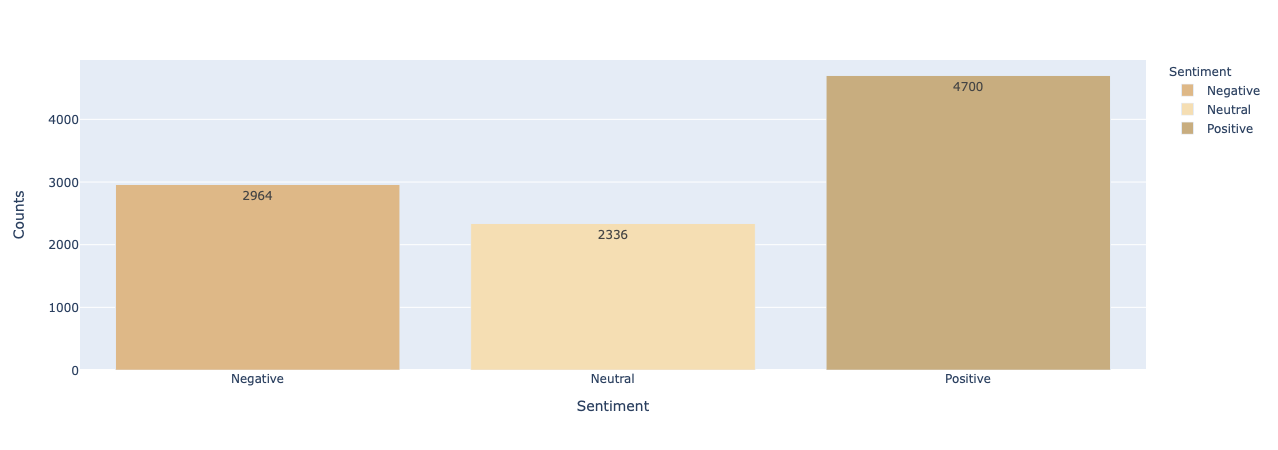

In [37]:
fig = px.bar(tweets,x="Sentiment",y= 'Counts',color='Sentiment',text="Counts",color_discrete_sequence=["#DEB887", "#F5DEB3", "#C8AD7F"],)
fig.show()

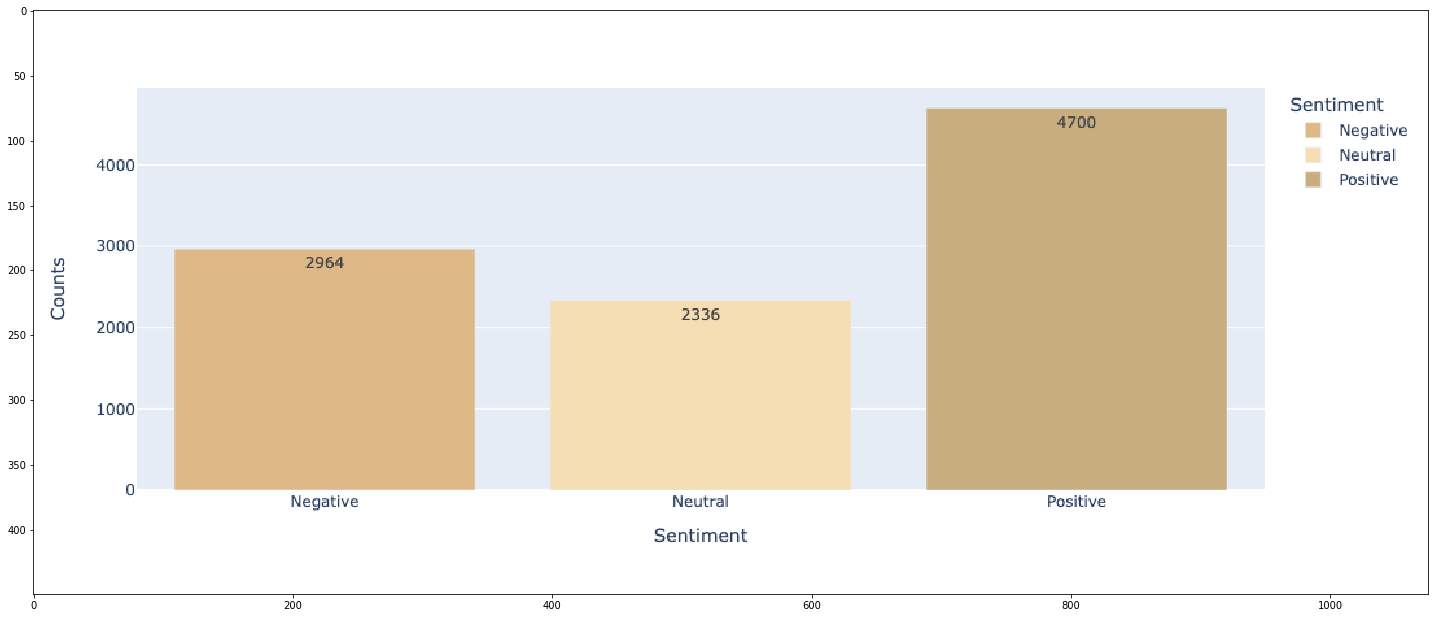

In [10]:

img = cv2.imread(r"images/sentiment.png")
plt.figure(figsize= (25,15))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

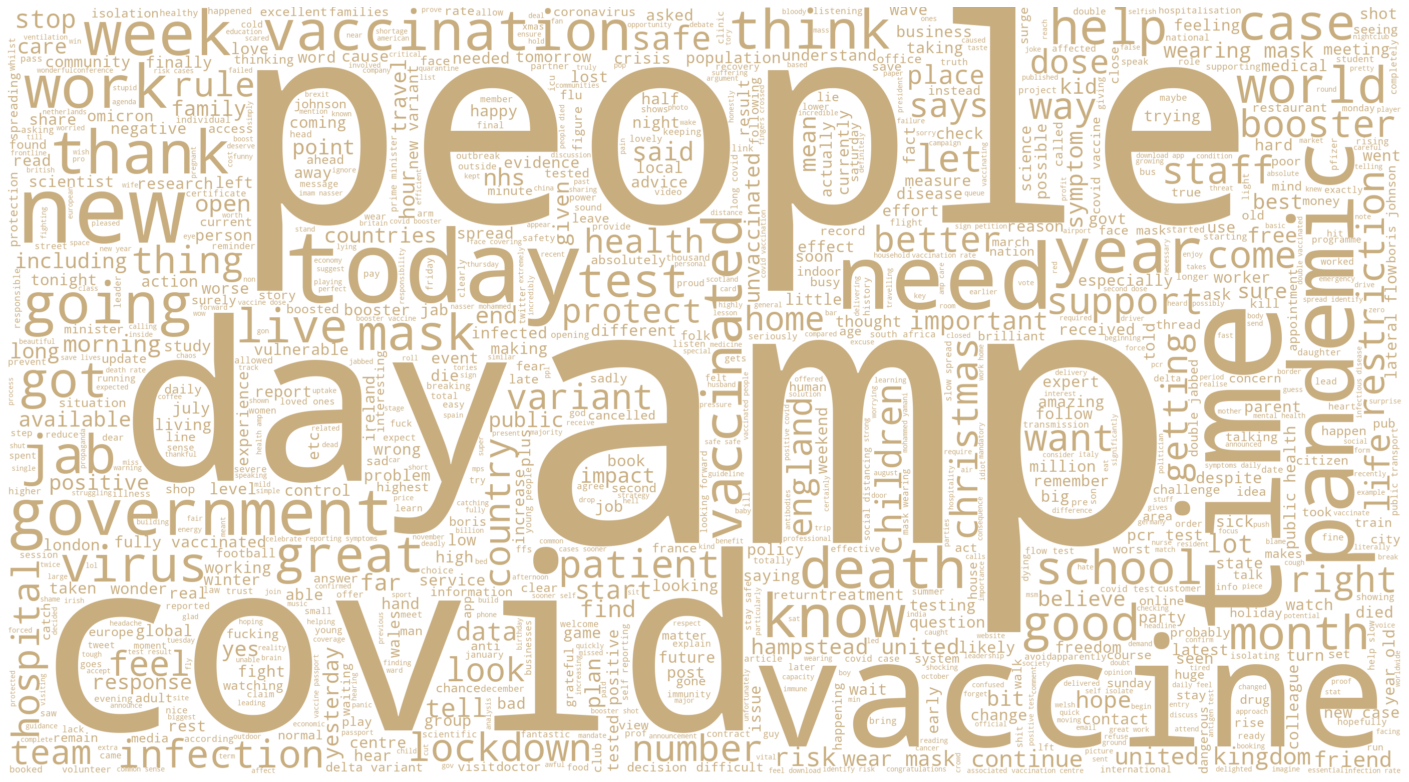

In [38]:
# 'WordCount of frequent words'
words= " ".join(tweet for tweet in df.clean_tweet)
mask=np.array(Image.open("images/mask.png"))
wordcloud=WordCloud(background_color="white",max_words=1000, mask=mask).generate(words)
image_colors=ImageColorGenerator(mask)
plt.figure(figsize=[25,15])
plt.imshow(wordcloud.recolor(color_func=image_colors),interpolation="bilinear")
plt.axis("off")
plt.show()   